In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import seaborn as sns
import geopandas as gpd
from scipy.stats import pearsonr

pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import warnings
warnings.filterwarnings('ignore')

In [2]:
%reload_ext sql
%config SqlMagic.autocommit=False
%config SqlMagic.autolimit=0
%config SqlMagic.autopandas=True
%config SqlMagic.displaylimit=200
%sql trino://localhost:9090/cuebiq/

# SQL engine
from trino.dbapi import connect 
from sqlalchemy import create_engine

class TrinoEngine():
    def __init__(self):
        conn = connect(
            host="localhost",
            port=9090,
            catalog="cuebiq"
        )
        self.cur = conn.cursor()
        self.engine = create_engine("trino://localhost:9090/cuebiq/")
    
    def execute_statement(self, query:str) -> list:
        """
        Create and drop statements.
        """
        self.cur.execute(query)
        return self.cur.fetchall()
    
    def read_sql(self, query:str) -> pd.DataFrame: 
        """
        Select and insert into operations.
        """
        return pd.read_sql(query, self.engine)

sql_engine = TrinoEngine()

In [1]:
#1. proportion based entropy
diversity_morning = pd.read_pickle("./output/LA_POI_diversity_202203_weekday_morning.pkl")  
diversity_noon = pd.read_pickle("./output/LA_POI_diversity_202203_weekday_noon.pkl")
diversity_afternoon = pd.read_pickle("./output/LA_POI_diversity_202203_weekday_afternoon.pkl")
diversity_evening = pd.read_pickle("./output/LA_POI_diversity_202203_weekday_evening.pkl")
print(diversity_morning.shape[0],diversity_noon.shape[0],diversity_afternoon.shape[0],diversity_evening.shape[0])

#2. duration weighted entropy
durdiversity_morning = pd.read_pickle("./output/LA_POI_durationbased_diversity_202203_weekday_morning.pkl")  
durdiversity_noon = pd.read_pickle("./output/LA_POI_durationbased_diversity_202203_weekday_noon.pkl")  
durdiversity_afternoon = pd.read_pickle("./output/LA_POI_durationbased_diversity_202203_weekday_afternoon.pkl")  
durdiversity_evening = pd.read_pickle("./output/LA_POI_durationbased_diversity_202203_weekday_evening.pkl")  
print(durdiversity_morning.shape[0],durdiversity_noon.shape[0],durdiversity_afternoon.shape[0],durdiversity_evening.shape[0])

# df_diversity1 = sub_df_visit_LA_race_poi[['place_id','scaled_entropy','class_dominant']]
# df_diversity2 = df_duration_byrace_diversity[['place_id','scaled_entropy','class_dominant','poi_lat','poi_lng','brand_name','sic_code','sic_name']]
# df_diversity2.rename(columns={'scaled_entropy': 'dur_scaled_entropy','class_dominant':'dur_class_dominant'}, inplace=True)
# print(df_diversity1.shape[0],df_diversity2.shape[0])
# df_diversity1 = pd.merge(df_diversity1,df_diversity2,on='place_id',how='left')
# print(df_diversity1.shape[0])

In [2]:
diversity_evening

In [15]:
def subset_and_rename(df,timeofday):
    df = df.assign(Time=timeofday)
    df = df[df['sic_code']==7011]  # select one POI type: 
    df = df[['scaled_entropy','Time']]
    return df

#5812.0 Eating Places,  5411.0 Grocery Stores, 7991.0 Physical Fitness Facilities
#7231.0 Beauty Shops, 6021.0 National Commercial Banks, 7011.0 Hotels and Motels 5311.0

In [16]:
diversity_morning2 = subset_and_rename(diversity_morning,'morning')
diversity_noon2 = subset_and_rename(diversity_noon,'noon')
diversity_afternoon2 = subset_and_rename(diversity_afternoon,'afternoon')
diversity_evening2 = subset_and_rename(diversity_evening,'evening')

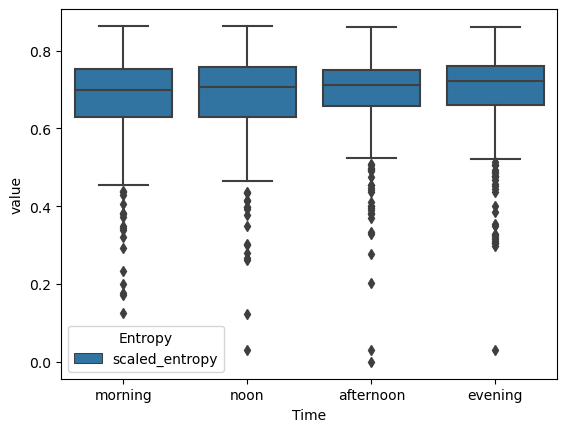

In [17]:
#this graph shows time of day variation of entropy for a specific POI catetogry
#just to get a sense of the dynamic of entropy, not very useful
cdf = pd.concat([diversity_morning2, diversity_noon2, diversity_afternoon2,diversity_evening2])
mdf = pd.melt(cdf, id_vars=['Time'], var_name=['Entropy'])
# print(mdf.head())
ax = sns.boxplot(x="Time", y="value", hue="Entropy", data=mdf)
plt.show()

## 1. Assign each POI their CBG id
not need to run again

In [38]:
df_poi_cat = pd.read_pickle("./output/LA_POI_category.pkl")
df_poi_cat = gpd.GeoDataFrame(
    df_poi_cat, geometry=gpd.points_from_xy(df_poi_cat.poi_lng, df_poi_cat.poi_lat), crs="EPSG:4326"
)
print(df_poi_cat.shape[0])
# df_poi_cat

62808


In [35]:
%%time
geography_table = "cuebiq.paas_cda_pe_v3.geography_registry"

# read LA CBG data
cbg_geom = sql_engine.read_sql(
    f"""
    select
        geography_id, geometry_wkt
    from {geography_table}
    where
        country_code = 'US'
        and geography_type_code = 'admin4'
        and geography_id like 'US.CA.037%'     --- <<< filter geometries in LA
    """
)

cbg_geom.rename(columns={'geography_id': 'block_group_id', 'geometry_wkt': 'geom'}, inplace=True)
# eliminate Catalina island and another island in the south of Catalina island
cbg_geom = cbg_geom[~cbg_geom['block_group_id'].isin(['US.CA.037.599100.2','US.CA.037.599000.2','US.CA.037.599000.1','US.CA.037.599000.4','US.CA.037.599000.3','US.CA.037.599100.1'])]

CPU times: user 233 ms, sys: 9.49 ms, total: 243 ms
Wall time: 8.33 s


In [36]:
%%time
cbg_geom['geom'] = gpd.GeoSeries.from_wkt(cbg_geom['geom'])
cbg_geom = gpd.GeoDataFrame(cbg_geom, geometry='geom')

pointInPoly = gpd.sjoin(df_poi_cat, cbg_geom, op='within') # each poi belongs to which CBG
pointInPoly.head()

In [39]:
df_poi_CBG = pointInPoly[['place_id','block_group_id']]

In [62]:
# df_poi_CBG.to_pickle('./output/LA_POI_belong_CBG.pkl')

## 2. correlate home based diversity with POI diversity

### assign each POI to their CBG and home based diversity

In [18]:
home_diversity = pd.read_pickle("./output/CA_CBG_dominantRace.pkl")
print('CA CBG home diversity:',home_diversity.shape[0])
home_diversity = home_diversity[home_diversity['scaled_entropy'].notna()]
print('CA CBG home diversity after removing NA:',home_diversity.shape[0])

df_poi_CBG = pd.read_pickle('./output/LA_POI_belong_CBG.pkl') # each POI belongs to which CBG
df_poi_CBG_merged = pd.merge(df_poi_CBG,home_diversity,on='block_group_id')
df_poi_CBG_mergedneed = df_poi_CBG_merged[['place_id','scaled_entropy','class_dominant']]
df_poi_CBG_mergedneed.rename(columns={'scaled_entropy': 'home_scaled_entropy','class_dominant':'home_class_dominant'}, inplace=True)
df_poi_CBG_mergedneed.head() # each POI's home based diversity

6425
6396


R_AfricanAmerican  R_AmericanIndianAlaska   R_Asian  R_HispanicLatinx   R_Other   R_White      block_group_id               class     dominant_race  population  scaled_entropy                       class_dominant
0  0.016970           0.0                     0.021818  0.366061          0.046061  0.549091  US.CA.037.123700.1  moderate diversity  R_White           825.0       0.553336        R_White_moderate diversity         
1  0.119872           0.0                     0.000000  0.880128          0.000000  0.000000  US.CA.037.226420.2  low diversity       R_HispanicLatinx  1560.0      0.204642        R_HispanicLatinx_low diversity     
2  0.269138           0.0                     0.060032  0.637389          0.016116  0.017325  US.CA.037.231220.1  moderate diversity  R_HispanicLatinx  2482.0      0.527955        R_HispanicLatinx_moderate diversity
3  0.271951           0.0                     0.000000  0.728049          0.000000  0.000000  US.CA.037.240401.1  low diversity       R_HispanicLatinx  1640.0      0.326601        R_HispanicLatinx_low diversity     
4  0.131188           0.0                     0.000000  0.803960          0.000000  0.064851  US.CA.037.242000.2  low diversity       R_HispanicLatinx  2020.0      0.345637        R_HispanicLatinx_low diversity

### merge with visit based diversity

In [20]:
totalDF = []
# diversity_morning.rename(columns={'class_dominant': 'morning_class_dominant'}, inplace=True)
# diversity_noon.rename(columns={'class_dominant': 'noon_class_dominant'}, inplace=True)
# diversity_afternoon.rename(columns={'class_dominant': 'afternoon_class_dominant'}, inplace=True)
# diversity_evening.rename(columns={'class_dominant': 'evening_class_dominant'}, inplace=True)

for df in [diversity_morning, diversity_noon, diversity_afternoon, diversity_evening]:
    df_merge = pd.merge(df[['place_id','class_dominant']],df_poi_CBG_mergedneed,on='place_id')
    print(df_merge.shape[0])

     # total number of POIs of each dominant class
    df_home_diverseclass = df_merge.groupby('home_class_dominant').count().reset_index()
    df_home_diverseclass = df_home_diverseclass[['home_class_dominant','place_id']]
    df_home_diverseclass.rename(columns={'place_id': 'sum'}, inplace=True) # sum: total number of POIs of each dominant class
    
    df_merge_grouped = df_merge[['place_id','home_class_dominant','class_dominant']].groupby(['home_class_dominant','class_dominant']).count().reset_index()
    df_merge_grouped.rename(columns={'place_id': 'count'}, inplace=True)
    df_merge_grouped = pd.merge(df_merge_grouped,df_home_diverseclass,on='home_class_dominant')
    df_merge_grouped['percent'] = df_merge_grouped['count']/df_merge_grouped['sum']*100
    df_merge_grouped['percent'] = df_merge_grouped['percent'].round(2)
    df_merge_grouped['home_class_dominant'] = 'home_' + df_merge_grouped['home_class_dominant'] # df_merge_grouped.head()
    print(df_merge_grouped.shape[0])
    totalDF.append(df_merge_grouped)

43814
80
45909
75
46319
76
41124
80


In [74]:
# group_morning.head()

In [ ]:
group_morning = totalDF[0].rename(columns={'sum':'morning_sum','percent':'morning_percent','count':'morning_count'})
group_noon = totalDF[1].rename(columns={'sum':'noon_sum','percent':'noon_percent','count':'noon_count'})
group_afternoon = totalDF[2].rename(columns={'sum':'afternoon_sum','percent':'afternoon_percent','count':'afternoon_count'})
group_evening = totalDF[3].rename(columns={'sum':'evening_sum','percent':'evening_percent','count':'evening_count'})

group_morning = group_morning[group_morning['morning_percent']>1]
group_noon = group_noon[group_noon['noon_percent']>1]
group_afternoon = group_afternoon[group_afternoon['afternoon_percent']>1]
group_evening = group_evening[group_evening['evening_percent']>1]

df_diversity_trend = pd.merge(group_morning,group_noon,on=['home_class_dominant','class_dominant'],how='outer')
df_diversity_trend = pd.merge(df_diversity_trend,group_afternoon,on=['home_class_dominant','class_dominant'],how='outer')
df_diversity_trend = pd.merge(df_diversity_trend,group_evening,on=['home_class_dominant','class_dominant'],how='outer')
df_diversity_trend = df_diversity_trend.fillna(0)
print(df_diversity_trend.shape[0])
df_diversity_trend.head()

In [63]:
# corr, pval = pearsonr(df_merge['scaled_entropy'], df_merge['home_scaled_entropy'])
# # view the correlation coefficient and p-value
# print("Correlation Coefficient:", corr)
# print("P-value:", pval)
# df_merge.head()

In [30]:
print(len(df_diversity_trend['home_class_dominant'].unique().tolist()))
print(df_diversity_trend['home_class_dominant'].unique().tolist())
print(len(df_diversity_trend['class_dominant'].unique().tolist()))
print(df_diversity_trend['class_dominant'].unique().tolist())

11
['home_R_AfricanAmerican_low diversity', 'home_R_AfricanAmerican_moderate diversity', 'home_R_AmericanIndianAlaska_low diversity', 'home_R_Asian_low diversity', 'home_R_Asian_moderate diversity', 'home_R_HispanicLatinx_low diversity', 'home_R_HispanicLatinx_moderate diversity', 'home_R_Other_moderate diversity', 'home_R_White_low diversity', 'home_R_White_moderate diversity', 'home_high diversity']
9
['R_AfricanAmerican_moderate diversity', 'R_HispanicLatinx_low diversity', 'R_HispanicLatinx_moderate diversity', 'high diversity', 'R_White_moderate diversity', 'R_Asian_moderate diversity', 'R_Asian_low diversity', 'R_White_low diversity', 'R_AfricanAmerican_low diversity']


# Line graph
show the time of the day variation of dominant class 

In [49]:
# cat = 'home_high diversity'
# plot_df = df_diversity_trend[df_diversity_trend['home_class_dominant']==cat]
# plot_df = plot_df[['class_dominant','morning_percent','noon_percent','afternoon_percent','evening_percent']]
# # plot_df
# f = plt.figure()
# plt.title(cat)
# plot_df.set_index('class_dominant').T.plot.line(ax=f.gca())
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

class_dominant  morning_percent  noon_percent  afternoon_percent  evening_percent
48  R_Asian_moderate diversity           2.24             1.62          1.27               1.20           
49  R_HispanicLatinx_low diversity       1.81             0.00          1.08               1.93           
50  R_HispanicLatinx_moderate diversity  44.58            41.41         41.75              41.52          
51  R_White_moderate diversity           22.19            22.34         20.49              21.21          
52  high diversity                       27.99            33.08         34.64              33.05

In [70]:
home_diversity[home_diversity['class_dominant']=='R_AmericanIndianAlaska_low diversity']

R_AfricanAmerican  R_AmericanIndianAlaska  R_Asian  R_HispanicLatinx  R_Other  R_White      block_group_id          class           dominant_race  population  scaled_entropy                        class_dominant
3180  0.0                1.0                     0.0      0.0               0.0      0.0      US.CA.037.504102.1  low diversity  R_AmericanIndianAlaska  9.0         0.0             R_AmericanIndianAlaska_low diversity
3642  0.0                1.0                     0.0      0.0               0.0      0.0      US.CA.037.980033.1  low diversity  R_AmericanIndianAlaska  14.0        0.0             R_AmericanIndianAlaska_low diversity

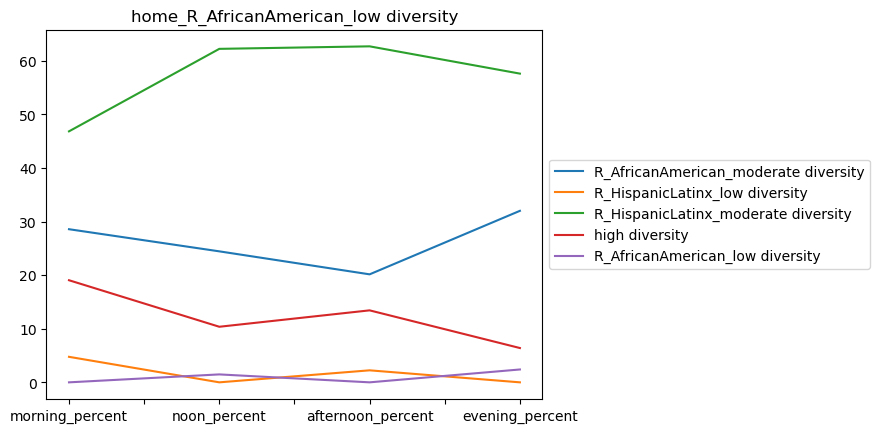

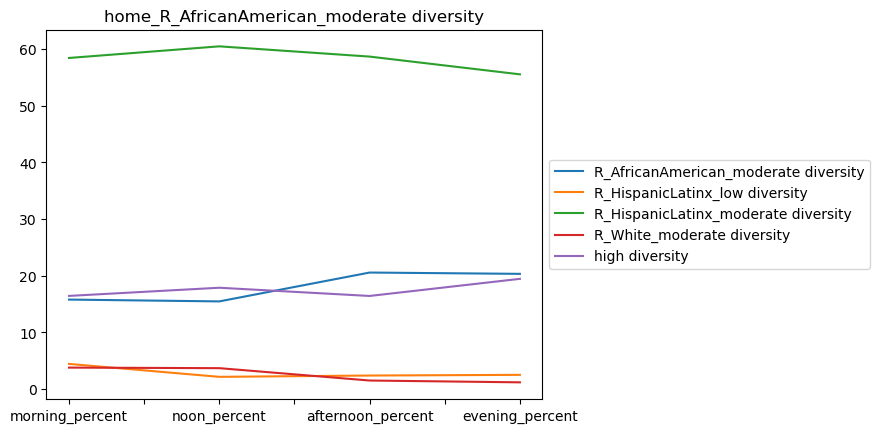

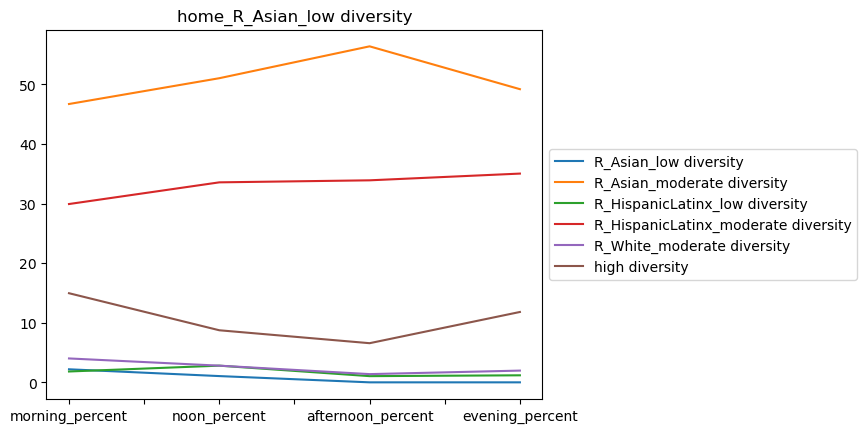

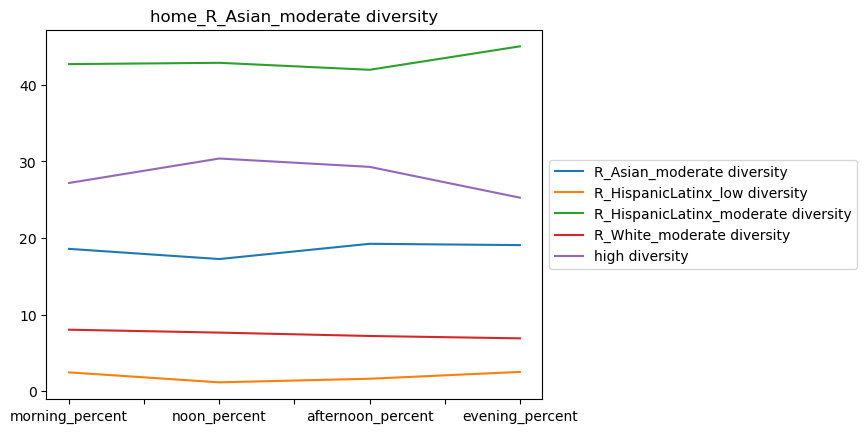

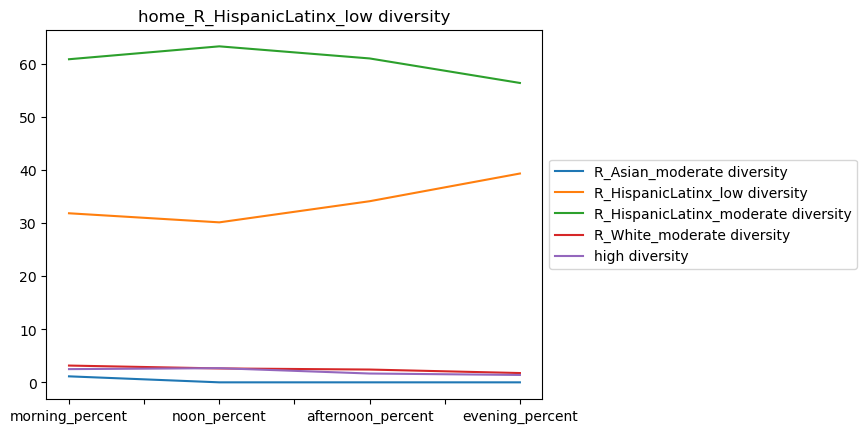

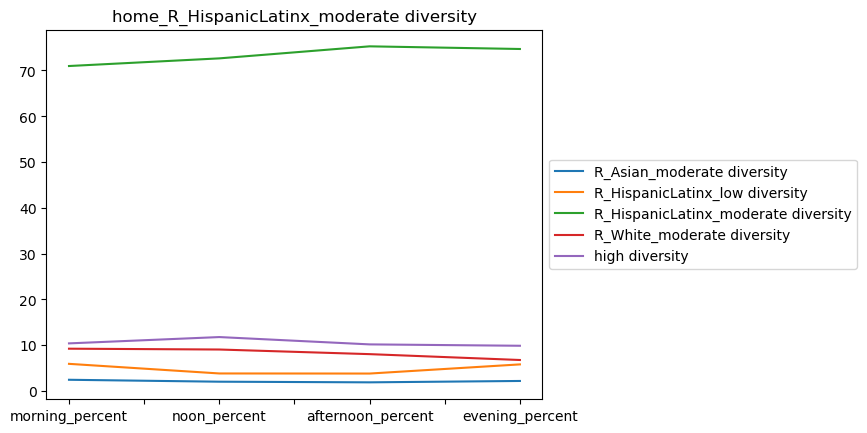

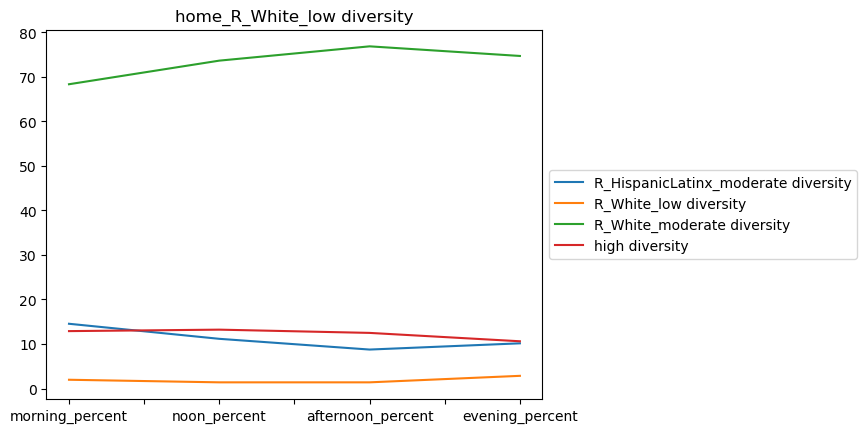

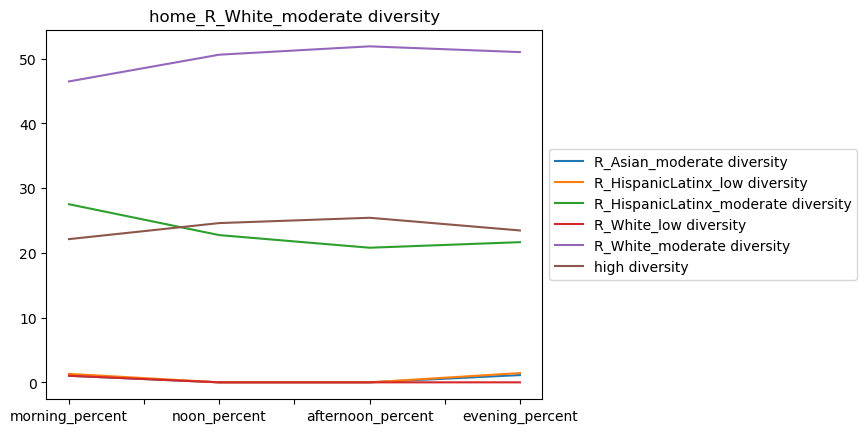

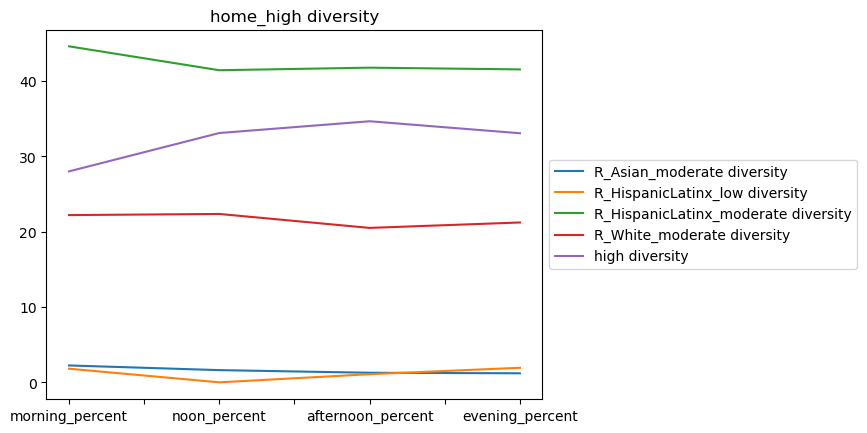

In [71]:
for cat in df_diversity_trend['home_class_dominant'].unique().tolist():
    if cat == 'home_R_Other_moderate diversity': continue
    if cat == 'home_R_AmericanIndianAlaska_low diversity': continue
    plot_df = df_diversity_trend[df_diversity_trend['home_class_dominant']==cat]
    plot_df = plot_df[['class_dominant','morning_percent','noon_percent','afternoon_percent','evening_percent']]
    f = plt.figure()
    plt.title(cat)
    plot_df.set_index('class_dominant').T.plot.line(ax=f.gca())
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

##  Sankey chart

In [31]:
plot_df = df_diversity_trend[df_diversity_trend['home_class_dominant']=='home_high diversity']
plot_df

home_class_dominant                       class_dominant  morning_count  morning_sum  morning_percent  noon_count  noon_sum  noon_percent  afternoon_count  afternoon_sum  afternoon_percent  evening_count  evening_sum  evening_percent
48  home_high diversity  R_Asian_moderate diversity           138.0          6173.0       2.24             106.0       6544.0    1.62          84.0             6599.0         1.27               71.0           5918.0       1.20           
49  home_high diversity  R_HispanicLatinx_low diversity       112.0          6173.0       1.81             0.0         0.0       0.00          71.0             6599.0         1.08               114.0          5918.0       1.93           
50  home_high diversity  R_HispanicLatinx_moderate diversity  2752.0         6173.0       44.58            2710.0      6544.0    41.41         2755.0           6599.0         41.75              2457.0         5918.0       41.52          
51  home_high diversity  R_White_moderate diversity           1370.0         6173.0       22.19            1462.0      6544.0    22.34         1352.0           6599.0         20.49              1255.0         5918.0       21.21          
52  home_high diversity  high diversity                       1728.0         6173.0       27.99            2165.0      6544.0    33.08         2286.0           6599.0         34.64              1956.0         5918.0       33.05

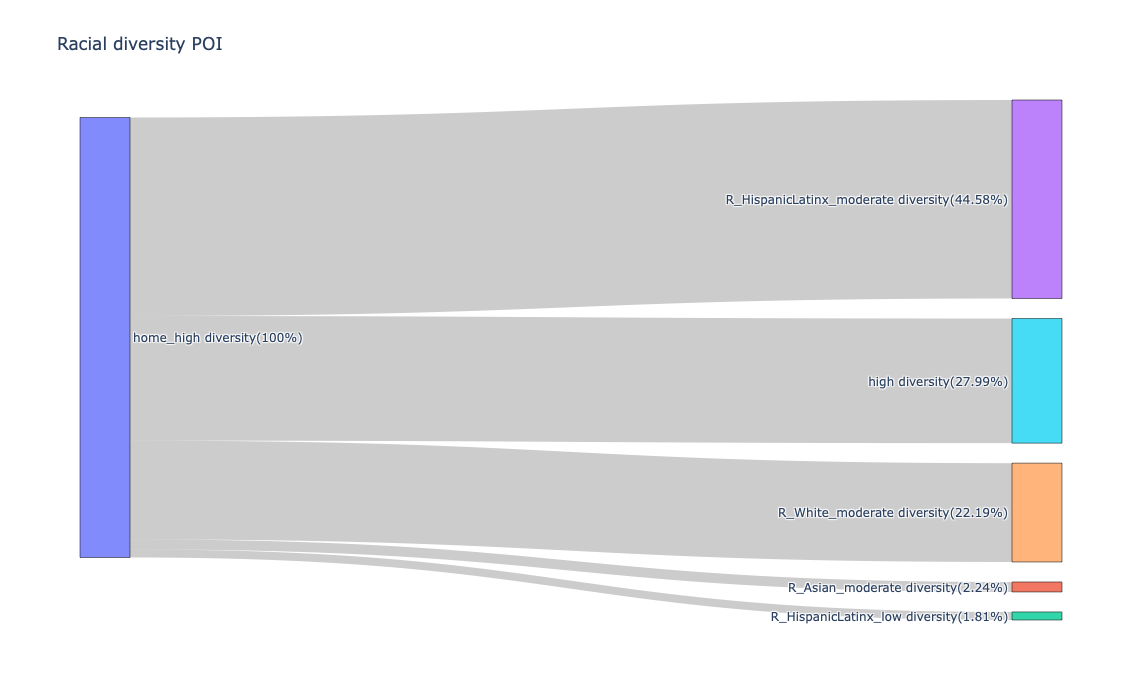

In [32]:
import pandas as pd
import plotly.graph_objects as go

vallist1 = plot_df['morning_percent'].tolist()

# Create the DataFrame
data = {
    'source': plot_df['home_class_dominant'].tolist(),
    'target': plot_df['class_dominant'].tolist(),
    'value': vallist1
}

df = pd.DataFrame(data)

vallist1.insert(0, 100)

labellist1 = plot_df['home_class_dominant'].unique().tolist() + plot_df['class_dominant'].unique().tolist()
# Create a dictionary to map labels to indices
label_indices = {label: idx for idx, label in enumerate(labellist1)}

node_label1 = [l + "(" + str(vallist1[i]) + '%)' for i,l in enumerate(labellist1)]

# Convert the labels to indices in the DataFrame
df['source_idx'] = df['source'].map(label_indices)
df['target_idx'] = df['target'].map(label_indices)

# Create the Sankey chart
fig = go.Figure(data=[go.Sankey(
    valuesuffix = "%",
    node=dict(
        pad=20,
        thickness=50,
        line=dict(color="black", width=0.5),
        label=node_label1,
        # color=colors_node
    ),
    link=dict(
        source=df['source_idx'],
        target=df['target_idx'],
        value=df['value'],
        # color=[colors_node[idx] for idx in df['source_idx']]
    ))])

fig.update_layout(title_text="Racial diversity POI", font_size=12, width=700, height=700)
fig.show()

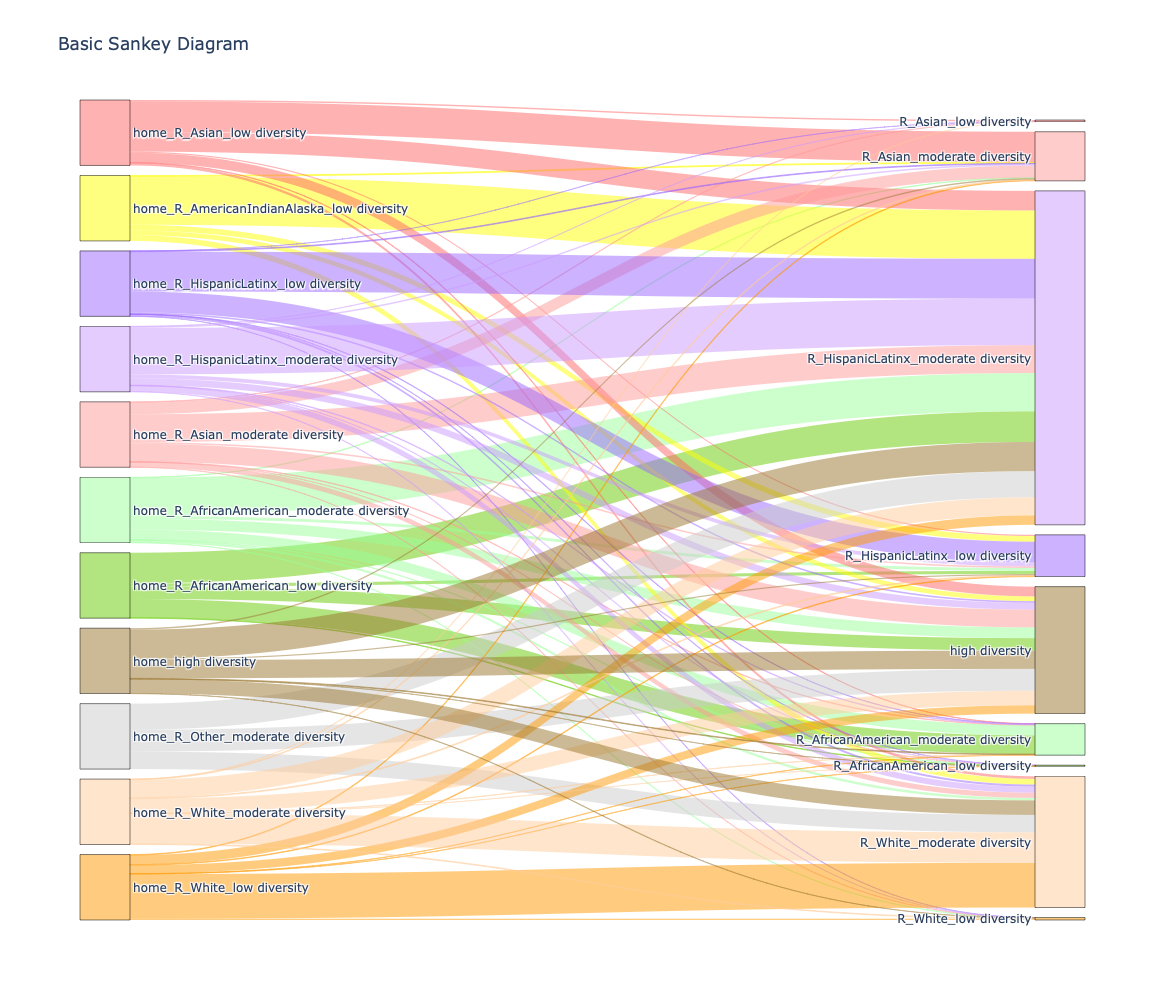

In [91]:
# import pandas as pd
# import plotly.graph_objects as go

# # Create the DataFrame
# data = {
#     'source': df_merge_grouped['home_class_dominant'].tolist(),
#     'target': df_merge_grouped['class_dominant'].tolist(),
#     'value': df_merge_grouped['percent'].tolist()
# }

# df = pd.DataFrame(data)

# # Create a dictionary to map labels to indices
# label_indices = {label: idx for idx, label in enumerate(['home_R_AfricanAmerican_low diversity',
#        'home_R_AfricanAmerican_moderate diversity',
#        'home_R_AmericanIndianAlaska_low diversity',
#        'home_R_Asian_low diversity', 'home_R_Asian_moderate diversity',
#        'home_R_HispanicLatinx_low diversity',
#        'home_R_HispanicLatinx_moderate diversity',
#        'home_R_Other_moderate diversity', 'home_R_White_low diversity',
#        'home_R_White_moderate diversity', 'home_high diversity',
#        'R_AfricanAmerican_low diversity',
#        'R_AfricanAmerican_moderate diversity', 'R_Asian_low diversity',
#        'R_Asian_moderate diversity', 'R_HispanicLatinx_low diversity',
#        'R_HispanicLatinx_moderate diversity',
#        'R_White_low diversity',
#        'R_White_moderate diversity', 'high diversity'])}

# # Convert the labels to indices in the DataFrame
# df['source_idx'] = df['source'].map(label_indices)
# df['target_idx'] = df['target'].map(label_indices)

# colors_node = ['rgba(102, 204, 0, 0.5)', 'rgba(153, 255, 153, 0.5)', 'rgba(255, 255, 0, 0.5)',
#           'rgba(255, 102, 102, 0.5)', 'rgba(255, 153, 153, 0.5)', 'rgba(153, 102, 255, 0.5)',
#           'rgba(204, 153, 255, 0.5)', 'rgba(204, 204, 204, 0.5)', 'rgba(255, 153, 0, 0.5)',
#           'rgba(255, 204, 153, 0.5)', 'rgba(153, 117, 46, 0.5)',
#                'rgba(102, 204, 0, 0.5)', 'rgba(153, 255, 153, 0.5)', 'rgba(255, 102, 102, 0.5)',
#           'rgba(255, 153, 153, 0.5)', 'rgba(153, 102, 255, 0.5)', 'rgba(204, 153, 255, 0.5)',
#           'rgba(255, 153, 0, 0.5)', 'rgba(255, 204, 153, 0.5)', 'rgba(153, 117, 46, 0.5)']

# # Create the Sankey chart
# fig = go.Figure(data=[go.Sankey(
#     valuesuffix = "%",
#     node=dict(
#         pad=10,
#         thickness=50,
#         line=dict(color="black", width=0.5),
#         label=list(label_indices.keys()),
#         color=colors_node
#     ),
#     link=dict(
#         source=df['source_idx'],
#         target=df['target_idx'],
#         value=df['value'],
#         color=[colors_node[idx] for idx in df['source_idx']]
#     ))])

# fig.update_layout(title_text="Basic Sankey Diagram", font_size=12, width=800, height=1000)
# fig.show()
